# The Preston Curve within the EU
**This project has been conducted by kmh698, hgz691, rcs266, xcv176**

## Introduction 

In a seminal contribution [Samuel Preston (1975)](https://www.tandfonline.com/doi/abs/10.1080/00324728.1975.10410201?casa_token=hU7dceoEZ5wAAAAA:zFBz11THZBhVCamZWVcosS4laNkdG3vl-E-jUu2vgMKfpPcCK5ONWhR75AsuYPgc5Mj4L2Y6Xfqq) documented that for a cross-section of countries, higher levels of income per capita are associated with greater life expectancy; the curve that fits the data best dubbed ‘the Prestoncurve’ by later research is concave. This promotes the idea that economic prosperity may lead to greater longevity, and that income inequality works to lower average longevity; the latter being a consequence of the observed concavity of the mapping between income and life expectancy [(Dalgaard & Strulik, 2014)](https://web.econ.ku.dk/dalgaard/Work/agingdeath_revision_2.pdf).

Yet, [Lutz, W., & Kebede, E. (2018)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6001628/), among others, argue that the observed correlation between income per capita and life expectancy may actually be driven by differences in edcuation, as education may improve both health (and hence life expectancy) and GDP per capita.

In this project, we are going to explore the link between GDP per capita, life expectancy, and education for areas within European states. In order to do so, we import data on GDP, population, life expectancy, and education from the [Eurostat database](https://ec.europa.eu/eurostat/data/database).

The assignment is structed as follows. First, we are going to load and clean the above mentioned datasets that we import from the Eurostat API. Thereafter, we explore all datasets together by creating a widget that plots life expectancy, GDP, education, and population over time  and by plotting venn diagrams showing the overlap of geographical areas. Afterwards, we merge all datasets and start with our analysis. In our analysis, we explore the dataset in more detail by particularly focusing on the relationship between life expectancy, gdp per capita, and education.

Imports and set magics:

In [42]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import numpy as np
import datetime
import pandas_datareader # install with `pip install pandas-datareader`
import pandas_datareader.data as web
#import pydst # install with `pip install git+https://github.com/elben10/pydst`

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
#! pip install matplotlib-venn
from matplotlib_venn import venn2 # `pip install matplotlib-venn`

import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets

import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import regions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

## Life expectancy data

**Read the life expectancy data from the Eurostat API and clean it**

In [43]:
# a. install Eurostat API
# pip install eust
#! pip install eust
# b. load
import eust

# c. downloads data on life expectancy for EU countries and their within country regions
eust.download_table('demo_r_mlifexp') 
my_tables = eust.list_tables()  # returns a list
assert 'demo_r_mlifexp' in my_tables # assert if mistake

# d. read the dataset
life = eust.read_table_data('demo_r_mlifexp') 

# e. print colum names and index
print(f' Initial column names in this data set is: {list(life.columns)}') # prints the column names
print(f' Inintial index names in the data set is: {list(life.index.names)}') # prints the index

# f. reset the index, such that the index names are now columns
life.reset_index(level=life.index.names, inplace=True)
print(f' Adjusted column names in this data set: {list(life.columns)}')

# g. only keep regions on the smallest level of aggregation (4 digits in geo code)
life = regions.only_keep_regions(life)

 Initial column names in this data set is: ['value', 'flag']
 Inintial index names in the data set is: ['unit', 'sex', 'age', 'geo', 'time']
 Initial column names in this data set is: ['value', 'flag']
 Inintial index names in the data set is: ['unit', 'sex', 'age', 'geo', 'time']
 Adjusted column names in this data set: ['unit', 'sex', 'age', 'geo', 'time', 'value', 'flag']
 Adjusted column names in this data set: ['unit', 'sex', 'age', 'geo', 'time', 'value', 'flag']


** Explore the columns:**
This data set contains a lot of columns, here we explore the features of the data columns. This helps us to find our which columns are essential for our analysis and which columns we can neglect.

In [44]:
def column_var(var_name):
    
    '''
    A function that prints unique values from a list
    '''
    
    # creating data container
    temp_list = []
    # looping over values of the list
    for i in var_name:
        # if the values is not already in the data container it appends it
        if i not in temp_list:
            temp_list.append(i)
    #returning a print of the values
    return temp_list

In [45]:
# explore columns: uncomment the following lines of code in order to see all print statements

# print('Posible unit divisions in this data set are:')
# print(column_var(life['unit']))

# print('Posible sex divisions in this data set are:')
# print(column_var(life['sex']))

# print('Posible age divisions in this data set are:')
# print(column_var(life['age']))

# print('Posible region divisions in this data set are:')
# print(column_var(life['geo']))

# print('Posible yearly divisions in this data set are:')
# print(column_var(life['time']))

We are only interested in the sex-aggregated recors in this analysis. Therefore, we only keep observations of life expectancy for the total propulation, i.e., we only keep entries where 'sex' equals 'T'.

In [46]:
# only keep sex-aggregated records
life = life[life['sex'].apply(lambda x: str(x) == 'T')]

We explore that as of now, the columns 'unit', 'sex', and 'flag' do not contain information relevant to our analysis. We therefore drop columns 'unit', 'sex', and 'flag'.

In [47]:
# drop the columns 'unit', 'sex', and 'flag'
drop_these = ['unit', 'sex', 'flag']
life.drop(drop_these, axis = 1, inplace = True)

**The dataset now looks like this:**

In [48]:
life.head()

,age,geo,time,value
2549100,Y1,AL01,1990,NaN
2549101,Y1,AL01,1991,NaN
2549102,Y1,AL01,1992,NaN
2549103,Y1,AL01,1993,NaN
2549104,Y1,AL01,1994,NaN


,age,geo,time,value
2549100,Y1,AL01,1990,NaN
2549101,Y1,AL01,1991,NaN
2549102,Y1,AL01,1992,NaN
2549103,Y1,AL01,1993,NaN
2549104,Y1,AL01,1994,NaN


Rather than keeping the column 'age', indicating at what age life expectancy is measured, we prefer having seperate variables, each denoting life expectancy at a respective age. We therefore create new columns, such that column 'Y1' contrains values representing the life expectancy at age 1, column 'Y2' contrains values representing the life expectancy at age 2, etc. 

In [49]:
# a. start by crearing an index variable that we can keep later
life['time_s'] = life.time.apply(str) # transforms time into a string
life['index'] = life['geo'] + life['time_s'] # generates a unique identifier for each row

# b. pivot table such that we get x columns for life expectancy at age x, respectively
life = life.pivot_table(index = ['geo', 'time', 'index'],
                        columns = ['age'], values = 'value').fillna(0)

# c. reset the index for geo and time
life.reset_index(level = (0,1), inplace = True)

**The dataset now looks like this:**

In [50]:
life.head()

age,geo,time,Y1,Y10,Y11,Y12,Y13,Y14,Y15,Y16,...,Y79,Y8,Y80,Y81,Y82,Y83,Y84,Y9,Y_GE85,Y_LT1
index,,,,,,,,,,,,,,,,,,,,,
AL012019,AL01,2019,78.5,69.7,68.8,67.8,66.8,65.9,64.9,63.9,...,7.9,71.7,7.4,6.8,6.2,5.7,5.2,70.7,4.8,78.7
AL022019,AL02,2019,81.5,72.6,71.6,70.6,69.6,68.6,67.6,66.6,...,10.4,74.5,9.8,9.3,8.8,8.3,8.0,73.5,7.8,81.6
AL032019,AL03,2019,77.0,68.1,67.1,66.2,65.2,64.2,63.2,62.2,...,5.6,70.1,4.9,4.3,3.6,3.0,2.3,69.1,1.6,77.4
AT111990,AT11,1990,75.0,66.1,65.1,64.1,63.1,62.1,61.2,60.2,...,7.4,68.1,7.0,6.6,6.2,5.9,5.5,67.1,5.1,75.7
AT111991,AT11,1991,74.3,65.5,64.5,63.5,62.5,61.6,60.6,59.6,...,7.5,67.5,7.0,6.6,6.2,5.9,5.5,66.5,5.3,74.8


age,geo,time,Y1,Y10,Y11,Y12,Y13,Y14,Y15,Y16,...,Y79,Y8,Y80,Y81,Y82,Y83,Y84,Y9,Y_GE85,Y_LT1
index,,,,,,,,,,,,,,,,,,,,,
AL012019,AL01,2019,78.5,69.7,68.8,67.8,66.8,65.9,64.9,63.9,...,7.9,71.7,7.4,6.8,6.2,5.7,5.2,70.7,4.8,78.7
AL022019,AL02,2019,81.5,72.6,71.6,70.6,69.6,68.6,67.6,66.6,...,10.4,74.5,9.8,9.3,8.8,8.3,8.0,73.5,7.8,81.6
AL032019,AL03,2019,77.0,68.1,67.1,66.2,65.2,64.2,63.2,62.2,...,5.6,70.1,4.9,4.3,3.6,3.0,2.3,69.1,1.6,77.4
AT111990,AT11,1990,75.0,66.1,65.1,64.1,63.1,62.1,61.2,60.2,...,7.4,68.1,7.0,6.6,6.2,5.9,5.5,67.1,5.1,75.7
AT111991,AT11,1991,74.3,65.5,64.5,63.5,62.5,61.6,60.6,59.6,...,7.5,67.5,7.0,6.6,6.2,5.9,5.5,66.5,5.3,74.8


## GDP data

**Read the GDP data from the Eurostat API and clean it**

In [51]:
# a. downloads data on GDP for EU countries and their within country regions
eust.download_table('nama_10r_2gdp')  # downloads data
my_tables = eust.list_tables() # returns a list
assert 'nama_10r_2gdp' in my_tables # assert if mistake

# b. read the dataset
gdp = eust.read_table_data('nama_10r_2gdp') 

# c. print colum names and index
print(list(gdp.columns)) # prints column names
print(list(gdp.index.names)) # prints the index

# d. reset the index, such that the index names are now columns
gdp.reset_index(level=gdp.index.names, inplace=True)
print(f' Adjusted column names in this data set: {list(gdp.columns)}')

# e. only keep regions on the smallest level of aggregation (4 digits in geo code)
gdp = regions.only_keep_regions(gdp)

['value', 'flag']
['unit', 'geo', 'time']
 Adjusted column names in this data set: ['unit', 'geo', 'time', 'value', 'flag']
['value', 'flag']
['unit', 'geo', 'time']
 Adjusted column names in this data set: ['unit', 'geo', 'time', 'value', 'flag']


**Explore the columns**

In [52]:
# explore columns: uncomment the following lines of code in order to see all print statements
 
# print('Posible unit divisions in this data set is:')
# print(column_var(gdp['unit']))

# print('Posible region divisions in this data set is:')
# print(column_var(gdp['geo']))

# print('Posible yearly divisions in this data set is:')
# print(column_var(gdp['time']))

# print('Posible age divisions in this data set is:')
# print(column_var(gdp['flags']))

The dataset contains different units of GDP measurement. We restrict our analysis to only focus on GDP in million purchasing power standards (PPS, EU27 from 2020). Hence, we only keep entries in the currency unit **[MIO_PPS_EU27_2020]**.

In [53]:
# only keep GDP in million purchasing power standards
gdp = gdp[gdp['unit'].apply(lambda x: str(x) == 'MIO_PPS_EU27_2020')]

We explore that as of now, the columns 'unit', and 'flag' do not contain information relevant to our analysis. We therefore drop columns 'unit', and 'flag'.

In [54]:
# Drop columns 'unit' and 'flag'
drop_these=['unit', 'flag']
gdp.drop(drop_these, axis=1, inplace=True)

Finally, we rename the column 'value' to 'gdp' such that the column name indicates that its values contain GDP measures.

In [55]:
# Rename variable
rename_dict={}
rename_dict['value'] = 'gdp'
gdp.rename(columns=rename_dict,inplace=True)

**The dataset now looks like this:**

In [56]:
gdp.head()

,geo,time,gdp
37380,AL01,2000,NaN
37381,AL01,2001,NaN
37382,AL01,2002,NaN
37383,AL01,2003,NaN
37384,AL01,2004,NaN


,geo,time,gdp
37380,AL01,2000,NaN
37381,AL01,2001,NaN
37382,AL01,2002,NaN
37383,AL01,2003,NaN
37384,AL01,2004,NaN


## Education data

**Read the education data from the Eurostat API and clean it**

In [57]:
# a. downloads data on education for EU countries and their within country regions
eust.download_table('edat_lfs_9917') # downloads data
my_tables = eust.list_tables() # returns a list
assert 'edat_lfs_9917' in my_tables # assert if mistake

# b. read the dataset
education = eust.read_table_data('edat_lfs_9917') 

# c. print colum names and index
print(list(education.columns)) # prints the columns
print(list(education.index.names)) # prints the index

# d. reset the index,  such that the index names are now columns
education.reset_index(level=education.index.names, inplace=True)

# e. only keep regions on the smallest level of aggregation (4 digits in geo code)
education = regions.only_keep_regions(education)

['value', 'flag']
['unit', 'sex', 'isced11', 'c_birth', 'age', 'geo', 'time']
['value', 'flag']
['unit', 'sex', 'isced11', 'c_birth', 'age', 'geo', 'time']


**Exploring the dataset**

In [58]:
# explore columns: uncomment the following lines of code in order to see all print statements

# print('Posible unit divisions in this data set are:')
# print(column_var(education['unit']))

# print('Posible sex divisions in this data set are:')
# print(column_var(education['sex']))

# print('Posible education divisions in this data set are:')
# print(column_var(education['isced11']))

# print('Posible county ob birth divisions in this data set are:')
# print(column_var(education['c_birth']))

# print('Posible age divisions in this data set are:')
# print(column_var(education['age']))

# print('Posible region divisions in this data set are:')
# print(column_var(education['geo']))

# print('Posible yearly divisions in this data set is:')
# print(column_var(gdp['time']))

# print('Posible age divisions in this data set is:')
# print(column_var(gdp['flags']))

We are only interested in the sex-aggregated records in this analysis. Therefore, we only keep observations of life expectancy for the total population, i.e., we only keep entries where 'sex' equals 'T'.

In [59]:
# only keep sex-aggregated records
education = education[education['sex'].apply(lambda x: str(x) == 'T')]

The column isced11 accounts for the ISCED 2011 categories for educational attainment at 1-digit level. These categories aggregate the following education levels:
Level 0 – Less than primary education
Level 1 – Primary education
Level 2 – Lower secondary education
Level 3 – Upper secondary education
Level 4 – Post-secondary non-tertiary education
Level 5 – Short-cycle tertiary education
Level 6 – Bachelor’s or equivalent level
Level 7 – Master’s or equivalent level
Level 8 – Doctoral or equivalent level.

Since the dataset is composed into four education categories, comprising levels 0-2, 3-4, 3-8, and 5-8, we have two categories capturing levels 3 to 8. In order to avoid overlaps, we drop education category ED3-8, because it is defined very broad. Doppring ED3-8 leaves us with categories ED0-2, ED3_4, and ED5-8. Hence, we only keep isced11 aggregation levels ED0-2, ED3_4, ED5-8 by dropping ED3-8.

In [60]:
# a. names of indexes where education is ED3-8
indexname = education[ education['isced11'] == 'ED3-8'].index

# b. delete these row indexes from education
education.drop(indexname , inplace=True)

# c. checkt the remaining aggregation levels
isced11_ed_new = []

for i in list(education['isced11']):
    if i not in isced11_ed_new:
        isced11_ed_new.append(i)

#print(isced11_ed_new)

Rather than keeping the column 'isced11', indicating whether the percentage of the population is measured by attainment levels ED0-2, ED3_4, or ED5-8, we prefer having seperate variables for each education aggregation level. We therefore create new columns, such that column 'ED0-2' contrains values representing the percentage of the population that achieved isced11 categories 0 to 2, column 'ED3_4' contrains values representing the percentage of the population that achieved isced11 categories 3 to 4, and 'ED5-8' contrains values representing the percentage of the population that achieved isced11 categories 5 to 8.

In [61]:
# a. start by crearing an index variable that we can keep later
education['time_s'] = education.time.apply(str)
education['index']= education['geo'] + education['time_s']

# b. pivot table such that we get 3 columns for ED0_2, ED3-4, and ED5-8, respectively
education = education.pivot_table(index=['geo', 'time', 'index'],
                        columns=['isced11'], values='value').fillna(0)

# c. reset the index for geo and time
education.reset_index(level = (0,1), inplace = True)

Finally, we rename the column 'ED0-2' and 'ED5-8' to 'ED0_2' and 'ED4_8' such that the column names follow the same structure for each education level.


In [62]:
# rename the education variables
rename_dict['ED0-2'] = 'ED0_2'
rename_dict['ED5-8'] = 'ED5_8'
education.rename(columns=rename_dict,inplace=True)

**The dataset now looks like this:**

In [63]:
education.head()

isced11,geo,time,ED0_2,ED3_4,ED5_8
index,,,,,
AT112004,AT11,2004,26.550000,55.966667,12.375
AT112005,AT11,2005,28.514286,57.275000,11.625
AT112006,AT11,2006,25.600000,58.331250,13.600
AT112007,AT11,2007,29.910000,60.881250,12.425
AT112008,AT11,2008,24.366667,61.460000,13.100


isced11,geo,time,ED0_2,ED3_4,ED5_8
index,,,,,
AT112004,AT11,2004,26.550000,55.966667,12.375
AT112005,AT11,2005,28.514286,57.275000,11.625
AT112006,AT11,2006,25.600000,58.331250,13.600
AT112007,AT11,2007,29.910000,60.881250,12.425
AT112008,AT11,2008,24.366667,61.460000,13.100


## Population data

In [64]:
# a. downloads data on population for EU countries and their within country regions
eust.download_table('nama_10r_3popgdp') # downloads data 
my_tables = eust.list_tables() # returns a list
assert 'nama_10r_3popgdp' in my_tables #assert if mistake

# b. read the dataset
pop = eust.read_table_data('nama_10r_3popgdp') 

# c. print colum names and index
print(list(pop.columns)) # prints the columns
print(list(pop.index.names)) # prints the index

# d. reset the index,  such that the index names are now columns
pop.reset_index(level=pop.index.names, inplace=True)

# e. only keep regions on the smallest level of aggregation (4 digits in geo code)
pop = regions.only_keep_regions(pop)

['value', 'flag']
['unit', 'geo', 'time']
['value', 'flag']
['unit', 'geo', 'time']


**Exploring the dataset**

In [65]:
# explore columns: uncomment the following lines of code in order to see all print statements

# print('Posible unit divisions in this data set are:')
# print(column_var(pop['unit']))

# print('Posible region divisions in this data set are:')
# print(column_var(pop['geo']))

# print('Posible yearly divisions in this data set is:')
# print(column_var(pop['time']))

# print('Posible age divisions in this data set is:')
# print(column_var(pop['flags']))

We explore that as of now, the columns 'unit', and 'flag' do not contain information relevant to our analysis. We therefore drop columns 'unit', and 'flag'.


In [66]:
# drop columns 'unit' and 'flag'
drop_these = ['unit', 'flag']
pop.drop(drop_these, axis=1, inplace=True)

Finally, we rename the column 'value' to 'pop' such that the column name indicates that its values contain population counts.

In [67]:
# rename column
rename_dict['value'] = 'pop'
pop.rename(columns=rename_dict,inplace=True)

**The dataset now looks like this:**

In [68]:
pop.head()

,geo,time,pop
42,AL01,2000,NaN
43,AL01,2001,NaN
44,AL01,2002,NaN
45,AL01,2003,NaN
46,AL01,2004,NaN


,geo,time,pop
42,AL01,2000,NaN
43,AL01,2001,NaN
44,AL01,2002,NaN
45,AL01,2003,NaN
46,AL01,2004,NaN


# Explore all four data sets together

In order to be able to **explore the raw data**, we here provide an **interactive plot** to show, respectively, life expectancy, GDP, education, and population in each geographical area

The **static plot** is:

In [69]:
def plot_all(life, gdp, education, pop, dataset, geo): 
    
    if dataset == 'Life expectancy':
        df = life
        y = ['Y_LT1', 'Y65', 'Y_GE85']
    elif dataset == 'GDP':
        df = gdp
        y = 'gdp'
    elif dataset == 'Education':
        df = education
        y = ['ED0_2', 'ED3_4', 'ED5_8']
    else:
        df = pop
        y = 'pop'
    
    I = df['geo'] == geo
    ax = df.loc[I,:].plot(x='time', y=y, style='-o')

interactive(children=(Dropdown(description='Variable', options=('Life expectancy', 'GDP', 'Education', 'Popula…

interactive(children=(Dropdown(description='Variable', options=('Life expectancy', 'GDP', 'Education', 'Popula…

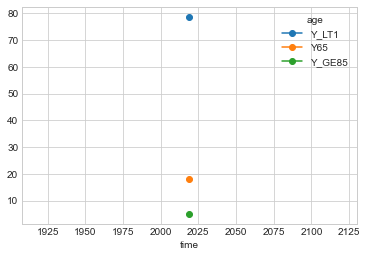

In [70]:
widgets.interact(plot_all, 
    
    
    life = widgets.fixed(life),
    gdp = widgets.fixed(gdp),
    education = widgets.fixed(education),
    pop = widgets.fixed(pop),
    dataset = widgets.Dropdown(description='Variable', 
                               options=['Life expectancy','GDP', 'Education', 'Population']),
    geo = widgets.Dropdown(description='Geographical area', 
                                    options=gdp.geo.unique())
                 
); 

We now illustrate that all four datasets have overlapping geographical areas by displaying venn diagrams:

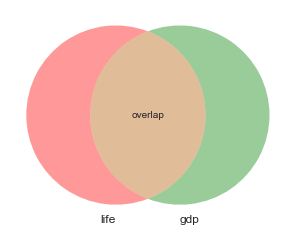

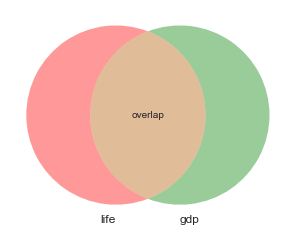

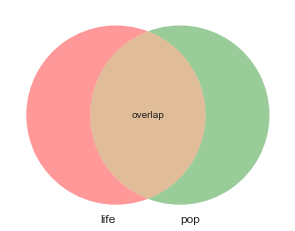

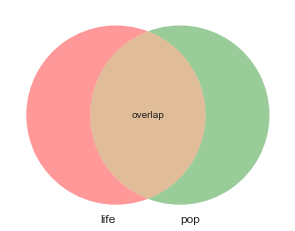

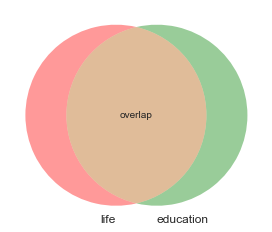

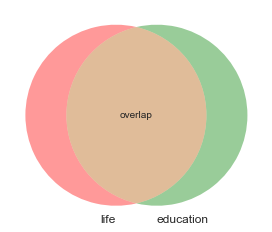

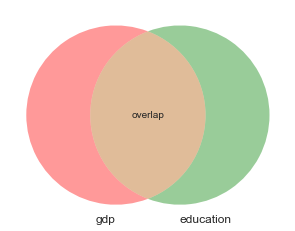

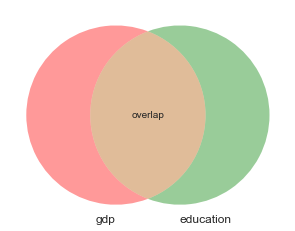

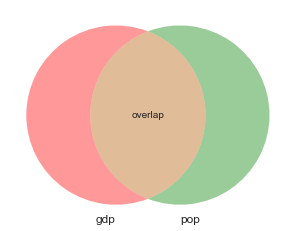

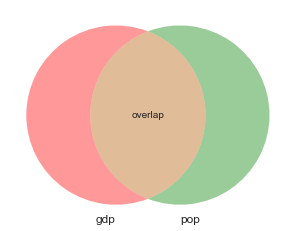

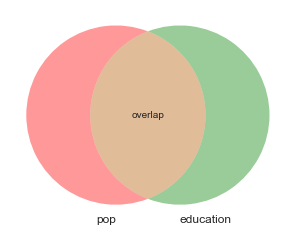

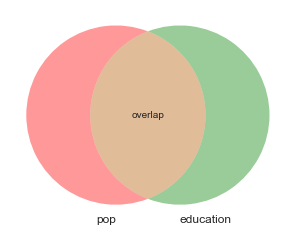

In [71]:
# a. overlapping geographical areas in life expectancy and GDP data
plt.figure(figsize=(8,4))
v = venn2(subsets = (4, 4, 5), set_labels = ('life', 'gdp'))
v.get_label_by_id('100').set_text('')
v.get_label_by_id('010').set_text('' )
v.get_label_by_id('110').set_text('overlap')
plt.show()

# b. overlapping geographical areas in life expectancy and population data
plt.figure(figsize=(8,4))
v = venn2(subsets = (4, 4, 5), set_labels = ('life', 'pop'))
v.get_label_by_id('100').set_text('')
v.get_label_by_id('010').set_text('' )
v.get_label_by_id('110').set_text('overlap')
plt.show()

# c. overlapping geographical areas in life expectancy and education data
plt.figure(figsize=(8,4))
v = venn2(subsets = (4, 4, 10), set_labels = ('life', 'education'))
v.get_label_by_id('100').set_text('')
v.get_label_by_id('010').set_text('' )
v.get_label_by_id('110').set_text('overlap')
plt.show()

# d. overlapping geographical areas in GDP and education data
plt.figure(figsize=(8,4))
v = venn2(subsets = (4, 4, 5), set_labels = ('gdp', 'education'))
v.get_label_by_id('100').set_text('')
v.get_label_by_id('010').set_text('' )
v.get_label_by_id('110').set_text('overlap')
plt.show()

# e. overlapping geographical areas in GDP and population data
plt.figure(figsize=(8,4))
v = venn2(subsets = (4, 4, 5), set_labels = ('gdp', 'pop'))
v.get_label_by_id('100').set_text('')
v.get_label_by_id('010').set_text('' )
v.get_label_by_id('110').set_text('overlap')
plt.show()

# f. overlapping geographical areas in population and education data
plt.figure(figsize=(8,4))
v = venn2(subsets = (4, 4, 5), set_labels = ('pop', 'education'))
v.get_label_by_id('100').set_text('')
v.get_label_by_id('010').set_text('' )
v.get_label_by_id('110').set_text('overlap')
plt.show()


# Merging data sets

We now create a data set that includes all geographical areas that are at least in our life expectancy data set by merging all datasets.

In [72]:
# a. merge dataset life and gdp
dataset_1 = pd.merge(life, gdp, on=['geo', 'time'], how='left')
dataset_1.head(5)

# b. merge with dataset education
dataset_2 = pd.merge(dataset_1, education, on=['geo', 'time'], how='left')
dataset_2.head(5)

# c. merge with dataset pop
ds = pd.merge(dataset_2, pop, on=['geo', 'time'], how='left')

# d. print areas and years
print(f'Number of geographical areas = {len(ds.geo.unique())}')
print(f'Number of years              = {len(ds.time.unique())}')

# e. the dataset now looks like this
ds.head(100)

Number of geographical areas = 332
Number of years              = 30
Number of geographical areas = 332
Number of years              = 30


,geo,time,Y1,Y10,Y11,Y12,Y13,Y14,Y15,Y16,...,Y83,Y84,Y9,Y_GE85,Y_LT1,gdp,ED0_2,ED3_4,ED5_8,pop
0,AL01,2019,78.5,69.7,68.8,67.8,66.8,65.9,64.9,63.9,...,5.7,5.2,70.7,4.8,78.7,6258.91,NaN,NaN,NaN,809.23
1,AL02,2019,81.5,72.6,71.6,70.6,69.6,68.6,67.6,66.6,...,8.3,8.0,73.5,7.8,81.6,13417.24,NaN,NaN,NaN,1173.19
2,AL03,2019,77.0,68.1,67.1,66.2,65.2,64.2,63.2,62.2,...,3.0,2.3,69.1,1.6,77.4,7503.71,NaN,NaN,NaN,871.77
3,AT11,1990,75.0,66.1,65.1,64.1,63.1,62.1,61.2,60.2,...,5.9,5.5,67.1,5.1,75.7,NaN,NaN,NaN,NaN,NaN
4,AT11,1991,74.3,65.5,64.5,63.5,62.5,61.6,60.6,59.6,...,5.9,5.5,66.5,5.3,74.8,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,AT21,1996,77.4,68.6,67.6,66.6,65.6,64.6,63.6,62.6,...,6.6,6.2,69.6,5.8,78.0,NaN,NaN,NaN,NaN,NaN
96,AT21,1997,77.5,68.6,67.7,66.7,65.7,64.7,63.7,62.7,...,6.7,6.3,69.6,6.0,78.1,NaN,NaN,NaN,NaN,NaN
97,AT21,1998,78.2,69.3,68.3,67.3,66.3,65.3,64.4,63.4,...,6.8,6.4,70.3,6.0,78.9,NaN,NaN,NaN,NaN,NaN
98,AT21,1999,77.7,68.9,67.9,66.9,65.9,64.9,64.0,63.0,...,6.9,6.5,69.9,6.1,78.5,NaN,NaN,NaN,NaN,NaN


,geo,time,Y1,Y10,Y11,Y12,Y13,Y14,Y15,Y16,...,Y83,Y84,Y9,Y_GE85,Y_LT1,gdp,ED0_2,ED3_4,ED5_8,pop
0,AL01,2019,78.5,69.7,68.8,67.8,66.8,65.9,64.9,63.9,...,5.7,5.2,70.7,4.8,78.7,6258.91,NaN,NaN,NaN,809.23
1,AL02,2019,81.5,72.6,71.6,70.6,69.6,68.6,67.6,66.6,...,8.3,8.0,73.5,7.8,81.6,13417.24,NaN,NaN,NaN,1173.19
2,AL03,2019,77.0,68.1,67.1,66.2,65.2,64.2,63.2,62.2,...,3.0,2.3,69.1,1.6,77.4,7503.71,NaN,NaN,NaN,871.77
3,AT11,1990,75.0,66.1,65.1,64.1,63.1,62.1,61.2,60.2,...,5.9,5.5,67.1,5.1,75.7,NaN,NaN,NaN,NaN,NaN
4,AT11,1991,74.3,65.5,64.5,63.5,62.5,61.6,60.6,59.6,...,5.9,5.5,66.5,5.3,74.8,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,AT21,1996,77.4,68.6,67.6,66.6,65.6,64.6,63.6,62.6,...,6.6,6.2,69.6,5.8,78.0,NaN,NaN,NaN,NaN,NaN
96,AT21,1997,77.5,68.6,67.7,66.7,65.7,64.7,63.7,62.7,...,6.7,6.3,69.6,6.0,78.1,NaN,NaN,NaN,NaN,NaN
97,AT21,1998,78.2,69.3,68.3,67.3,66.3,65.3,64.4,63.4,...,6.8,6.4,70.3,6.0,78.9,NaN,NaN,NaN,NaN,NaN
98,AT21,1999,77.7,68.9,67.9,66.9,65.9,64.9,64.0,63.0,...,6.9,6.5,69.9,6.1,78.5,NaN,NaN,NaN,NaN,NaN


# Analysis

In order to analyze the relationship between life expectancy, gdp per capita, and education, we calculate GDP per capita by dividing GDP by the population size.

In [73]:
# create a variable capturing gdp per capita
ds['gdp_pc'] = ds['gdp']/ds['pop']
ds['time'] = pd.to_numeric(ds['time'])

We now display the summary statistics of our dataset.

In [74]:
# print summary statistics
ds.describe()

,time,Y1,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,...,Y84,Y9,Y_GE85,Y_LT1,gdp,ED0_2,ED3_4,ED5_8,pop,gdp_pc
count,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,...,7413.000000,7413.000000,7413.000000,7413.000000,4798.000000,4677.000000,4677.000000,4677.000000,4784.000000,4777.000000
mean,2006.582086,78.339026,69.466370,68.474558,67.483016,66.491717,65.501848,64.513948,63.529583,62.548685,...,6.626319,70.458438,6.216134,78.937610,46356.391824,32.197766,43.549365,25.630341,1886.812023,23.692531
std,8.257912,2.931965,2.882082,2.878697,2.876446,2.873886,2.870987,2.867265,2.863878,2.859270,...,0.867787,2.884850,0.830519,3.092485,56665.866307,14.908098,12.617689,10.557358,1687.526423,10.249607
min,1990.000000,66.600000,57.900000,56.900000,55.900000,54.900000,54.000000,53.000000,52.000000,51.100000,...,2.300000,58.800000,1.600000,66.600000,681.530000,4.800000,0.000000,0.000000,25.740000,4.009008
25%,2000.000000,76.900000,68.000000,67.000000,66.000000,65.100000,64.100000,63.100000,62.100000,61.100000,...,6.100000,69.000000,5.700000,77.400000,15611.342500,22.050000,34.955556,17.938889,843.640000,16.705443
50%,2007.000000,78.800000,69.900000,68.900000,67.900000,66.900000,65.900000,64.900000,64.000000,63.000000,...,6.700000,70.900000,6.200000,79.400000,30900.420000,28.625000,42.593750,24.405263,1446.370000,22.467848
75%,2014.000000,80.500000,71.500000,70.600000,69.600000,68.600000,67.600000,66.600000,65.600000,64.600000,...,7.100000,72.500000,6.700000,81.200000,55982.237500,40.888889,53.260000,31.650000,2348.825000,29.033864
max,2019.000000,85.000000,76.000000,75.000000,74.000000,73.000000,72.000000,71.000000,70.000000,69.000000,...,9.800000,77.000000,9.600000,85.800000,698588.400000,88.816667,81.008333,75.683333,15293.410000,79.634755


,time,Y1,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,...,Y84,Y9,Y_GE85,Y_LT1,gdp,ED0_2,ED3_4,ED5_8,pop,gdp_pc
count,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,...,7413.000000,7413.000000,7413.000000,7413.000000,4798.000000,4677.000000,4677.000000,4677.000000,4784.000000,4777.000000
mean,2006.582086,78.339026,69.466370,68.474558,67.483016,66.491717,65.501848,64.513948,63.529583,62.548685,...,6.626319,70.458438,6.216134,78.937610,46356.391824,32.197766,43.549365,25.630341,1886.812023,23.692531
std,8.257912,2.931965,2.882082,2.878697,2.876446,2.873886,2.870987,2.867265,2.863878,2.859270,...,0.867787,2.884850,0.830519,3.092485,56665.866307,14.908098,12.617689,10.557358,1687.526423,10.249607
min,1990.000000,66.600000,57.900000,56.900000,55.900000,54.900000,54.000000,53.000000,52.000000,51.100000,...,2.300000,58.800000,1.600000,66.600000,681.530000,4.800000,0.000000,0.000000,25.740000,4.009008
25%,2000.000000,76.900000,68.000000,67.000000,66.000000,65.100000,64.100000,63.100000,62.100000,61.100000,...,6.100000,69.000000,5.700000,77.400000,15611.342500,22.050000,34.955556,17.938889,843.640000,16.705443
50%,2007.000000,78.800000,69.900000,68.900000,67.900000,66.900000,65.900000,64.900000,64.000000,63.000000,...,6.700000,70.900000,6.200000,79.400000,30900.420000,28.625000,42.593750,24.405263,1446.370000,22.467848
75%,2014.000000,80.500000,71.500000,70.600000,69.600000,68.600000,67.600000,66.600000,65.600000,64.600000,...,7.100000,72.500000,6.700000,81.200000,55982.237500,40.888889,53.260000,31.650000,2348.825000,29.033864
max,2019.000000,85.000000,76.000000,75.000000,74.000000,73.000000,72.000000,71.000000,70.000000,69.000000,...,9.800000,77.000000,9.600000,85.800000,698588.400000,88.816667,81.008333,75.683333,15293.410000,79.634755


To get a quick overview of the data, we show the mean as well as the standard deviation by year:

In [75]:
# print mean and std by year
ds.groupby('time').agg(['mean','std']).round(2)

Y1          Y10          Y11          Y12          Y13        ...  \
       mean   std   mean   std   mean   std   mean   std   mean   std  ...   
time                                                                   ...   
1990  75.43  2.47  66.66  2.37  65.67  2.37  64.69  2.37  63.70  2.36  ...   
1991  75.34  2.68  66.56  2.60  65.57  2.60  64.59  2.59  63.60  2.60  ...   
1992  75.37  2.83  66.57  2.76  65.59  2.75  64.60  2.75  63.61  2.75  ...   
1993  75.71  2.60  66.90  2.55  65.91  2.55  64.92  2.54  63.93  2.54  ...   
1994  76.06  2.66  67.24  2.60  66.25  2.60  65.27  2.60  64.28  2.60  ...   
1995  75.93  2.88  67.11  2.81  66.12  2.81  65.14  2.80  64.15  2.80  ...   
1996  76.18  2.81  67.36  2.75  66.37  2.74  65.38  2.74  64.39  2.73  ...   
1997  76.49  2.72  67.66  2.67  66.67  2.67  65.68  2.67  64.69  2.66  ...   
1998  76.65  2.70  67.80  2.66  66.81  2.65  65.82  2.65  64.84  2.65  ...   
1999  76.90  2.46  68.04  2.42  67.05  2.42  66.06  2.42  65.07  2.42  ...   
2000  77.18  2.40  68.31  2.37  67.32  2.37  66.33  2.37  65.34  2.37  ...   
2001  77.61  2.38  68.73  2.35  67.74  2.34  66.75  2.34  65.76  2.34  ...   
2002  77.54  2.32  68.67  2.30  67.68  2.30  66.68  2.30  65.69  2.29  ...   
2003  77.57  2.28  68.69  2.26  67.70  2.26  66.71  2.26  65.72  2.25  ...   
2004  77.96  2.55  69.07  2.51  68.08  2.52  67.09  2.52  66.10  2.51  ...   
2005  78.03  2.59  69.16  2.55  68.17  2.55  67.17  2.55  66.18  2.55  ...   
2006  78.45  2.65  69.56  2.62  68.57  2.62  67.57  2.62  66.58  2.62  ...   
2007  78.62  2.63  69.73  2.60  68.74  2.60  67.75  2.60  66.75  2.60  ...   
2008  78.81  2.54  69.92  2.52  68.92  2.52  67.94  2.52  66.94  2.51  ...   
2009  78.81  2.57  69.94  2.52  68.95  2.51  67.96  2.51  66.97  2.50  ...   
2010  79.10  2.54  70.23  2.49  69.24  2.48  68.25  2.48  67.25  2.48  ...   
2011  79.37  2.47  70.50  2.42  69.50  2.42  68.51  2.41  67.52  2.42  ...   
2012  79.46  2.35  70.57  2.32  69.57  2.32  68.58  2.32  67.58  2.31  ...   
2013  79.72  2.32  70.83  2.29  69.83  2.29  68.84  2.29  67.84  2.28  ...   
2014  79.99  2.41  71.09  2.38  70.09  2.38  69.10  2.38  68.11  2.38  ...   
2015  79.75  2.33  70.84  2.30  69.85  2.30  68.86  2.29  67.87  2.29  ...   
2016  80.05  2.36  71.14  2.33  70.15  2.33  69.16  2.33  68.16  2.33  ...   
2017  79.98  2.41  71.07  2.38  70.08  2.38  69.08  2.38  68.09  2.38  ...   
2018  80.08  2.44  71.17  2.41  70.18  2.41  69.19  2.41  68.19  2.41  ...   
2019  80.26  2.54  71.35  2.51  70.36  2.51  69.37  2.51  68.37  2.51  ...   

      ED0_2         ED3_4         ED5_8             pop          gdp_pc         
       mean    std   mean    std   mean    std     mean      std   mean    std  
time                                                                            
1990    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1991    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1992    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1993    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1994    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1995    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1996    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1997    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1998    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1999    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
2000    NaN    NaN    NaN    NaN    NaN    NaN  1724.29  1673.60  17.32   7.42  
2001    NaN    NaN    NaN    NaN    NaN    NaN  1676.25  1640.14  19.09   7.54  
2002    NaN    NaN    NaN    NaN    NaN    NaN  1799.71  1561.85  19.84   7.78  
2003    NaN    NaN    NaN    NaN    NaN    NaN  1799.89  1575.81  20.32   7.78  
2004  35.02  13.68  45.09  12.66  20.83   8.07  1848.04  

Y1          Y10          Y11          Y12          Y13        ...  \
       mean   std   mean   std   mean   std   mean   std   mean   std  ...   
time                                                                   ...   
1990  75.43  2.47  66.66  2.37  65.67  2.37  64.69  2.37  63.70  2.36  ...   
1991  75.34  2.68  66.56  2.60  65.57  2.60  64.59  2.59  63.60  2.60  ...   
1992  75.37  2.83  66.57  2.76  65.59  2.75  64.60  2.75  63.61  2.75  ...   
1993  75.71  2.60  66.90  2.55  65.91  2.55  64.92  2.54  63.93  2.54  ...   
1994  76.06  2.66  67.24  2.60  66.25  2.60  65.27  2.60  64.28  2.60  ...   
1995  75.93  2.88  67.11  2.81  66.12  2.81  65.14  2.80  64.15  2.80  ...   
1996  76.18  2.81  67.36  2.75  66.37  2.74  65.38  2.74  64.39  2.73  ...   
1997  76.49  2.72  67.66  2.67  66.67  2.67  65.68  2.67  64.69  2.66  ...   
1998  76.65  2.70  67.80  2.66  66.81  2.65  65.82  2.65  64.84  2.65  ...   
1999  76.90  2.46  68.04  2.42  67.05  2.42  66.06  2.42  65.07  2.42  ...   
2000  77.18  2.40  68.31  2.37  67.32  2.37  66.33  2.37  65.34  2.37  ...   
2001  77.61  2.38  68.73  2.35  67.74  2.34  66.75  2.34  65.76  2.34  ...   
2002  77.54  2.32  68.67  2.30  67.68  2.30  66.68  2.30  65.69  2.29  ...   
2003  77.57  2.28  68.69  2.26  67.70  2.26  66.71  2.26  65.72  2.25  ...   
2004  77.96  2.55  69.07  2.51  68.08  2.52  67.09  2.52  66.10  2.51  ...   
2005  78.03  2.59  69.16  2.55  68.17  2.55  67.17  2.55  66.18  2.55  ...   
2006  78.45  2.65  69.56  2.62  68.57  2.62  67.57  2.62  66.58  2.62  ...   
2007  78.62  2.63  69.73  2.60  68.74  2.60  67.75  2.60  66.75  2.60  ...   
2008  78.81  2.54  69.92  2.52  68.92  2.52  67.94  2.52  66.94  2.51  ...   
2009  78.81  2.57  69.94  2.52  68.95  2.51  67.96  2.51  66.97  2.50  ...   
2010  79.10  2.54  70.23  2.49  69.24  2.48  68.25  2.48  67.25  2.48  ...   
2011  79.37  2.47  70.50  2.42  69.50  2.42  68.51  2.41  67.52  2.42  ...   
2012  79.46  2.35  70.57  2.32  69.57  2.32  68.58  2.32  67.58  2.31  ...   
2013  79.72  2.32  70.83  2.29  69.83  2.29  68.84  2.29  67.84  2.28  ...   
2014  79.99  2.41  71.09  2.38  70.09  2.38  69.10  2.38  68.11  2.38  ...   
2015  79.75  2.33  70.84  2.30  69.85  2.30  68.86  2.29  67.87  2.29  ...   
2016  80.05  2.36  71.14  2.33  70.15  2.33  69.16  2.33  68.16  2.33  ...   
2017  79.98  2.41  71.07  2.38  70.08  2.38  69.08  2.38  68.09  2.38  ...   
2018  80.08  2.44  71.17  2.41  70.18  2.41  69.19  2.41  68.19  2.41  ...   
2019  80.26  2.54  71.35  2.51  70.36  2.51  69.37  2.51  68.37  2.51  ...   

      ED0_2         ED3_4         ED5_8             pop          gdp_pc         
       mean    std   mean    std   mean    std     mean      std   mean    std  
time                                                                            
1990    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1991    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1992    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1993    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1994    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1995    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1996    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1997    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1998    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1999    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
2000    NaN    NaN    NaN    NaN    NaN    NaN  1724.29  1673.60  17.32   7.42  
2001    NaN    NaN    NaN    NaN    NaN    NaN  1676.25  1640.14  19.09   7.54  
2002    NaN    NaN    NaN    NaN    NaN    NaN  1799.71  1561.85  19.84   7.78  
2003    NaN    NaN    NaN    NaN    NaN    NaN  1799.89  1575.81  20.32   7.78  
2004  35.02  13.68  45.09  12.66  20.83   8.07  1848.04  

## We now create a widget that allows us to plot life expectancy against GDP per capita and education

interactive(children=(IntSlider(value=2001, continuous_update=False, description='Year:', max=2020, min=2001),…

interactive(children=(IntSlider(value=2001, continuous_update=False, description='Year:', max=2020, min=2001),…

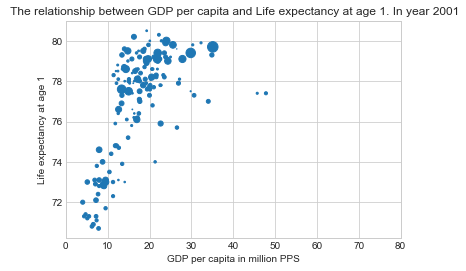

()

In [76]:
def widgetupdate(val,age,year):
    
    '''
    function that adjust label, title and axis limits for different variables chosen
    '''
    
    
    # costumisation for gdp per capita
    if val == 'gdp_pc':
        plt.xlabel('GDP per capita in million PPS')
        plt.title(f' The relationship between GDP per capita and Life expectancy at age {age}. In year {year}',loc='center')
        plt.xlim([0, 80])
        

    # costumisation low education
    elif val == 'ED0_2':
        plt.xlabel('Percentage of poplation with low degree of education')
        plt.title(f' The relationship between share of population with low education and Life expectancy at age {age}. In year {year}',loc='center')
        plt.xlim([0, 100])
   # costumisation for medium education
    elif val == 'ED3_4':
        plt.xlabel('Percentage of poplation with medium degree of education')
        plt.title(f' The relationship between share of population with medium education and Life expectancy at age {age}. In year {year}',loc='center')
        plt.xlim([0, 100])
    ## costumisation for high education
    elif val == 'ED5_8':
        plt.xlabel('Percentage of poplation with high degree of education')
        plt.title(f' The relationship between share of population with high education and Life expectancy at age {age}. In year {year}',loc='center')
        plt.xlim([0, 100])
    else:
        pass
# things we want to plot
vals= ('GDP per capita', 'gdp_pc'), ('Share with low education', 'ED0_2'), ('Share with medium education', 'ED3_4'),('Share with high education','ED5_8')


def series(year, age, x_axis):

    for i in range(year):
        
        # slicing the data set by year for the slider
        ds_ = ds[ds['time'] == i ]
        # the x and y axis of choice
        x=ds_[str(x_axis)]
        y=ds_['Y'+str(age)]
        
        # scaling the dots
        population = ds_['pop']/100
        
    print('No education data before 2005')
            
    plt.scatter(x,y,s=population )
    widgetupdate(x_axis,age,year)
    

    plt.ylabel(f'Life expectancy at age {str(age)}')
    
    return()

interact(series, year = widgets.IntSlider(
    min=min(column_var(gdp['time']))+1,
    max=max(column_var(gdp['time'])),
    step=1,
    description='Year:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'),
         
    age= widgets.IntSlider(
    value=1,
    min=1,
    max=65,
    step=1,
    description='Age:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'), 
         
    x_axis= widgets.Dropdown(
    options=vals,
    description='X axis:',
    disabled=False,));


We can see that when plotting GDP per capita against life expectancy, we find a positive relationship between the two. Based on this graphical analysis we confirm that the Preston Curve also exists across regions within the EU. The relationship between education and life expectancy is less clear. Still, when considering the percentage of the population who attained education levels equivalent to at least some form of tertiary education (levels 5-8), we find a positive relationship between education and life expectancy.

**The following interactive figure automatically displays the relationship of interest over time.**

interactive(children=(Play(value=2001, description='Press play', interval=2000, max=2020, min=2001), IntSlider…

interactive(children=(Play(value=2001, description='Press play', interval=2000, max=2020, min=2001), IntSlider…

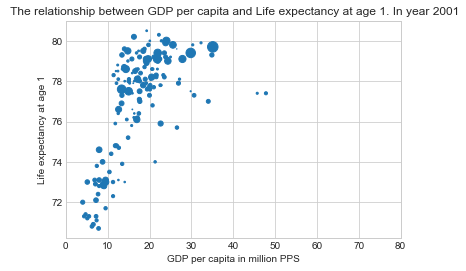

()

In [77]:
interact(series,

         
    year = widgets.Play( value = min(column_var(gdp['time']))+1,
    min=min(column_var(gdp['time']))+1,
    max=max(column_var(gdp['time'])),
    step=1,
    interval =2000,
    description='Press play',
    disabled=False,
    continuous_update=False),
         
    age= widgets.IntSlider(
    value=1,
    min=1,
    max=65,
    step=1,
    description='Age:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'), 
         
    x_axis= widgets.Dropdown(
    options=vals,
    description='X axis:',
    disabled=False));


In order to also anlayze the relationship between GDP per capita and education, we will create an interactive plot that allows us to regress life expectancy (at any age), GDP per capita, and education (at its verious aggregation levels) against each oterh

## We now create a widget that allows to plot all columns against each other

In [78]:
# Update the things we want to plot

life_val = []
for i in range(1,66):
    stuff = 'Life expectancy at the age of '+str(i)
    val = 'Y'+str(i)
    together = stuff,val
    
    life_val.append(together)
    

life_vals = tuple(life_val)
vals2 = vals + life_vals


In [79]:
def series2(year, x_axis, y_axis):

    for i in range(year):
        # slicing the data set by year for the slider
        ds_ = ds[ds['time'] == i ]
        # the x and y axis of choice
        x=ds_[str(x_axis)]
        y=ds_[str(y_axis)]
        
        # scaling the dots
        population = ds_['pop']/100
        
    print('No education data before 2005')
            
    plt.scatter(x,y,s=population )
    if x_axis == 'gdp_pc':
        plt.xlabel('GDP per capita in million PPS')
        plt.xlim([0, 80])
        

    # costumisation low education
    elif x_axis == 'ED0_2':
        plt.xlabel('Percentage of poplation with low degree of education')
        plt.xlim([0, 100])
   # costumisation for medium education
    elif x_axis == 'ED3_4':
        plt.xlabel('Percentage of poplation with medium degree of education')
        plt.xlim([0, 100])
    ## costumisation for high education
    elif x_axis == 'ED5_8':
        plt.xlabel('Percentage of poplation with high degree of education')
        plt.xlim([0, 100])
    else:
        plt.xlabel(f'Life expectancy at the age of: {x_axis[1:]}')

    
    # costumisation for gdp per capita
    if y_axis == 'gdp_pc':
        plt.ylabel('GDP per capita in million PPS')
        plt.ylim([0, 80])
        

    # costumisation low education
    elif y_axis == 'ED0_2':
        plt.ylabel('Percentage of poplation with low degree of education')
        plt.ylim([0, 100])
   # costumisation for medium education
    elif y_axis == 'ED3_4':
        plt.xlabel('Percentage of poplation with medium degree of education')
        plt.ylim([0, 100])
    ## costumisation for high education
    elif y_axis == 'ED5_8':
        plt.xlabel('Percentage of poplation with high degree of education')
        plt.ylim([0, 100])
    else:
        plt.ylabel(f'Life expectancy at the age of: {y_axis[1:]}')

    
    return()

interact(series2, year = widgets.IntSlider(
    min=min(column_var(gdp['time']))+1,
    max=max(column_var(gdp['time'])),
    step=1,
    description='Year:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'),
         

    x_axis= widgets.Dropdown(
    options=vals2,
    description='X axis:',
    disabled=False),
    
    y_axis= widgets.Dropdown(
    options=vals2,
    description='Y axis:',
    disabled=False));


interactive(children=(IntSlider(value=2001, continuous_update=False, description='Year:', max=2020, min=2001),…

interactive(children=(IntSlider(value=2001, continuous_update=False, description='Year:', max=2020, min=2001),…

We can confirm a positive relationship between GDP per capita and higher education. However, the link between GDP per capita and lower or medium education levels is less clear.

## We now present the relationships with regression lines of various orders

In [80]:
# variables not to plot
ex = ['time', 'geo']

# variables to plot
var_list = [element for element in ds.columns if element not in ex]
def series3(year, order, x_axis, y_axis):
    '''
    A function that plots regression lines 
    for the chosen variables and at a chosen order of polynomial
    for a chosen year
    '''
    print('No education data before 2005')
    for i in range(year):
        #slicing the data set by year for the slider
        ds_ = ds[ds['time'] == i ]
        # the x and y axis of choice
        x=ds_[str(x_axis)]
        y=ds_[str(y_axis)]
        
    
    for o in range(order):
        #plotting regression at the chosen order polynomial
        fig = sns.regplot(x=x, y=y, data=ds_,
                 scatter_kws={"s":20, 'alpha':0.2},
                    order=o,
                    color = 'blue')
        if x_axis == 'gdp_pc':
            fig.set(xlabel='GDP per Capita')

        # costumisation low education
        elif x_axis == 'ED0_2':        

            fig.set(xlabel='Percentage of poplation with low degree of education')

       # costumisation for medium education
        elif x_axis == 'ED3_4':
            
            fig.set(xlabel='Percentage of poplation with medium degree of education')
        ## costumisation for high education
        elif x_axis == 'ED5_8':
            
            fig.set(xlabel='Percentage of poplation with high degree of education')

        else:
            fig.set(xlabel=f'Life expectancy at the age of: {x_axis[1:]}')


        # costumisation for gdp per capita
        if y_axis == 'gdp_pc':
            fig.set(ylabel='GDP per Capita')


        # costumisation low education
        elif y_axis == 'ED0_2':
            fig.set(ylabel='Percentage of poplation with low degree of education')
       # costumisation for medium education
        elif y_axis == 'ED3_4':
            plt.xlabel('Percentage of poplation with medium degree of education')
            plt.ylim([0, 100])
        ## costumisation for high education
        elif y_axis == 'ED5_8':
            
            fig.set(ylabel='Percentage of poplation with high degree of education')
        else:
            fig.set(ylabel=f'Life expectancy at the age of: {y_axis[1:]}')
        
     

    
    return()
interact(series3, year = widgets.IntSlider(
    min=min(column_var(gdp['time']))+1,
    max=max(column_var(gdp['time'])),
    step=1,
    description='Year:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'), 
    
         
    
         
         
    order=widgets.IntSlider(
    min=1,
    max=5,
    step=1,
    description='Order:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'), 
         
         
    x_axis= widgets.Dropdown(
    options=vals2,
    description='X axis:',
    disabled=False),
         
    y_axis= widgets.Dropdown(
    options=vals2,
    description='Y axis:',
    disabled=False));




interactive(children=(IntSlider(value=2001, continuous_update=False, description='Year:', max=2020, min=2001),…

interactive(children=(IntSlider(value=2001, continuous_update=False, description='Year:', max=2020, min=2001),…

We see that some of the variation is better explained with higher order regressions. Therefore, we run two regressions - one linear and one polynomial. For life expectancy at birth with GDP per capita and with share of highly educated as well as for the share of highly educated and GDP per capita.

In [81]:
# a. defining squared versions of the variables for the second order regressions
ds['gdp_pc_sq'] = ds['gdp_pc']**2
ds['ED5_8_sq'] = ds['ED5_8']**2

# b. preparing the data for regression
dfgg = ds.groupby(['Y1', 'gdp_pc', 'gdp_pc_sq', 'ED5_8']).mean().reset_index()


# c. running the regressions
reg1 = smf.ols('Y1 ~ gdp_pc',
              dfgg).fit()

reg2 = smf.ols('Y1 ~ gdp_pc + gdp_pc_sq',
              dfgg).fit()

reg3 = smf.ols('Y1 ~ ED5_8',
              dfgg).fit()

reg4 = smf.ols('Y1 ~ ED5_8 + ED5_8_sq',
              dfgg).fit()

reg5 = smf.ols('ED5_8 ~ gdp_pc',
              dfgg).fit()

reg6 = smf.ols('ED5_8 ~ gdp_pc + gdp_pc_sq',
              dfgg).fit()

# d. printing summaries 
print(reg1.summary())
print(reg2.summary())
print(reg3.summary())
print(reg4.summary())
print(reg5.summary())
print(reg6.summary())



                            OLS Regression Results                            
Dep. Variable:                     Y1   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     1883.
Date:                Wed, 13 Apr 2022   Prob (F-statistic):               0.00
Time:                        15:44:03   Log-Likelihood:                -8662.0
No. Observations:                3954   AIC:                         1.733e+04
Df Residuals:                    3952   BIC:                         1.734e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     75.7092      0.088    858.023      0.0

                            OLS Regression Results                            
Dep. Variable:                     Y1   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     1883.
Date:                Wed, 13 Apr 2022   Prob (F-statistic):               0.00
Time:                        15:44:03   Log-Likelihood:                -8662.0
No. Observations:                3954   AIC:                         1.733e+04
Df Residuals:                    3952   BIC:                         1.734e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     75.7092      0.088    858.023      0.0

We find a positive and statistically significant relationship between GDP per capita and life expectancy at age 1 in both the linear and the quadratic specification. Yet, from the quadratic specification's result tables we can observe that the link between GDP per capita and life expectancy is concave - as in the 'Preston curve'. If we were to assume a causal interpretation, this would imply yhat GDP per capita affects life expectancy at a positive but declining rate.

When investigating the relationship between higher education (level 5-8) and life expectancy and age 1, we also find a positive, statistically significant link both in the linear and quadratic specification. Similar to the link between GDP per capita and life expectancy, we find the relationship between education and life expectancy to be concave - as in the 'Preston curve'. If we were to assume a causal interpretation, this would imply that education affects life expectancy at a positive, but decreasing rate. 

Finally, when investigating the relationship between GDP per capita and education (level 5-8), we find a positive link in the linear and the quadratic specification. However, while GDP per capita is significantly related to education in both specifications, squared GDP per is not significantly related to education (despite showing a negative sign). Hence, the correlation between GDP per capita and higher education is linear rather than concave.

Overall, our results indicate a positive association between GDP per capita and life expectancy, GDP per capita and higher education, and between higher education and life expectancy. Yet, we only observe the 'Preston curve' shape, i.e., a concave relationship when regressing life expectancy on GDP per capita or education, not if we regress education on GDP per capita.

In [82]:
# Summarizing the regression parameters

print(f'Life expectancy and GDP pc \n\nParameters for the single linear regression: \n{reg1.params}')
print(f'The r sqared:\n{reg1.rsquared}')

print(f'The coefficient of interest for the polynomial regression:\n{reg2.params}')
print(f'The r sqared:\n{reg2.rsquared}')

print(f'\n\nLife expectancy and education \n\nParameters for the single linear regression: \n{reg3.params}')
print(f'The r sqared:\n{reg3.rsquared}')

print(f'The coefficient of interest for the polynomial regression:\n{reg4.params}')
print(f'The r sqared:\n{reg4.rsquared}')

print(f'\n\nEducation and GDP pc \n\nParameters for the single linear regression: \n{reg3.params}')
print(f'The r sqared:\n{reg5.rsquared}')

print(f'The coefficient of interest for the polynomial regression:\n{reg6.params}')
print(f'The r sqared:\n{reg6.rsquared}')


Life expectancy and GDP pc 

Parameters for the single linear regression: 
Intercept    75.709194
gdp_pc        0.143001
dtype: float64
The r sqared:
0.3227002119453156
The coefficient of interest for the polynomial regression:
Intercept    71.717736
gdp_pc        0.458845
gdp_pc_sq    -0.005294
dtype: float64
The r sqared:
0.46875056938170956


Life expectancy and education 

Parameters for the single linear regression: 
Intercept    77.205663
ED5_8         0.086081
dtype: float64
The r sqared:
0.09194912576488778
The coefficient of interest for the polynomial regression:
Intercept    75.267011
ED5_8         0.253342
ED5_8_sq     -0.003124
dtype: float64
The r sqared:
0.11449753309346289


Education and GDP pc 

Parameters for the single linear regression: 
Intercept    77.205663
ED5_8         0.086081
dtype: float64
The r sqared:
0.30955763556850413
The coefficient of interest for the polynomial regression:
Intercept    10.522886
gdp_pc        0.563435
gdp_pc_sq    -0.001174
dtype: f

# Conclusion

This assignment sought to explore the relationship between life expectancy and real GDP per capita, life expectancy and education, as well as education and GDP per capita, using cross-sectional data on different regions within European countries drawn from the database Eurostat. 

We use four different data sets: One on life expectancy, one on GDP, one on population, and one on education level.

After cleaning and exploring our datasets, we merge the datasets and calculate real GDP per capita.

We observe that it is indeed possible to find the 'Preston curve' within European reagions using the aforementioned data - both graphically as well as by running regressions. We find a significant and positive correlation between GDP per capita and life expectancy, GDP per capita and higher education, as well as higher education and life expectancy. Importantly, we observe a concave relationship, i.e., a 'Preston curve' shape only if we regress life expectancy on GDP per capita or higher education, yet not if we regress higher education on GDP per capita.

This means that it may well be the case that the original 'Preston curve' - referring to the positive, but concave link between GDP per capita and life expectancy may indeed be counfounded by omitting education. However, attempting to make causal interpretaions is beyond the scope of this analysis. We should be particularly concerned with simultaneity and omitted variable bias, threateing the robustness of our findings. Besides, reverse causality may be at play. One could argue that the direction of causality is such that better health as proxied by life expectancy causes higher income levels, because a healthier population, on average, tends to be more productive than does a less healthy population. Better health may also influence GDP per capita through its effect on education. This is plausible as we find positive and significant correlation between education and GDP per capita in both the linear and squared specification. Hence, we cannot draw a clear conlcusion on the direction of causality.